## Lab- Linear Regression with L2 Regularization - Bias-Variance tradeoff

**Objectives**: Implement Regularized Linear Regression algorithm and use it to study the bias-variance tradeoff.

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat


### Loading the data

The task is to implement regularized linear regression to predict the amount of water owing out of a dam using the change of water level in a reservoir. 

You will examine the effects of bias versus variance.

File *ex5data1.mat* contains historical records on the change in the water level, x, and the amount of water owing out of the dam, y. The dataset is divided into the following parts:

• Training set ( X, y) used to fit the model.

• Cross Validation (CV) / dev set (Xval, yval) for determining the regularization parameter.

• Test set (Xtest, ytest) for evaluating performance. These are examples which the model did not see during training. 


In [2]:
# Use loadmat to load the matlab file ex5data1.mat and extract train, val and test subsets.
mat = loadmat("ex5data1.mat")

X= mat['X']
y= mat['y']

Xval= mat["Xval"]
yval= mat["yval"]

Xtest= mat["Xtest"]
ytest= mat["ytest"]

m = len(y)  # Number of training examples 
mval = len(yval) # Number of CV/dev examples 
mtest = len(ytest)  # Number of testing examples 


### Plot the data

Plot the training data and get a figure similar to Fig.1. 

<img src="images/f1.png" style="width:350px;height:250px;">
<caption><center> **Fig. 1** : **Training data** </center></caption>

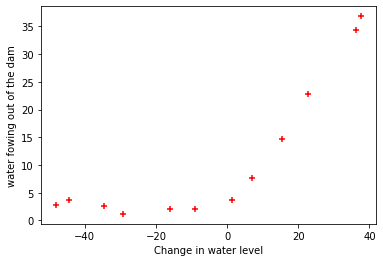

In [3]:
# Create Fig.1. Consult similar code from previous labs 

plt.scatter(X[:, 0], y[:, 0], c="r", marker="+")

plt.xlabel("Change in water level")
plt.ylabel("water fowing out of the dam")
plt.show() 


### Regularized Linear Regression Cost (Loss) Function

Now, you will implement Linear Regression to fit a straight line to the data and plot the learning curves. 

The regularized Linear Regression Cost (Loss) Function is:

$J(\theta) = \frac{1}{2m} (\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})^2) + \frac{\lambda}{2m}(\sum_{j=1}^n \theta_j^2)$

Recall that $\lambda$ is the regularization parameter which helps preventing overfitting. The regularization term puts a penalty on the overall cost $J(\theta)$, $\theta_0$  is not regularized.  

Complete the code in function *linearRegCostFunction* to calculate the Regularized Linear Regression Cost (Loss) function and its gradients with respect to  $\theta$. 

In [32]:
def linearRegCostFunction(X, y, theta, Lambda):
    
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the linear regression model.
    
    """
    
    # Number of training examples 
    m = len(X)
    
    #linear regression model
    
    h = np.dot(X,theta)
    square_err=np.square(h-y)
    cost = 1/(2*m) * np.sum(square_err)
    reg_cost = cost + Lambda/(2*m) * (np.sum(theta[1:]**2))
    
    # compute the gradient
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    #  make the complete gradient a column vector
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return reg_cost, grad_all
    

### Fitting Linear Regression

Once the cost function and the gradients are computed correctly, run *gradientDescent* to compute the optimal values of $\theta$. 

Here, we set the regularization parameter $\lambda$ = 0. Because the linear regression is trying to fit a 2D $\theta$, regularization will not be much helpful for $\theta$ of such low dimension. 

In [33]:
def gradientDescent(X,y,theta,learn_rate,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        cost, grad = linearRegCostFunction(X,y,theta,Lambda)
        theta = theta - (learn_rate * grad)
        J_history.append(cost)
    
    return theta, J_history

In [34]:
# add an extra columns of 1 to X (recall axis=0 are the rows, axis=1 are the columns)
X_1 = np.append(X,np.ones((len(X),1)),axis=1)

Lambda = 0
learn_rate=0.001
#choose an adequate number of iterations such that the cost function converged 
num_iter= 10000

# inicialize all theta at 0. 
initial_theta = np.zeros((X_1.shape[1], 1))


#compute the optimal theta : EXPECTED RESULT: theta= [~12; ~0.36]
theta, J_history = gradientDescent(X_1,y,initial_theta,learn_rate,num_iter,Lambda)
print(theta)


[[ 0.36777442]
 [13.0871011 ]]


### Plot the Cost Function history

Text(0.5, 1.0, 'Cost function using Gradient Descent')

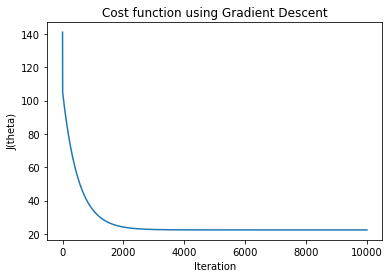

In [35]:

plt.plot(J_history)
plt.xlabel('Iteration')
plt.ylabel('J(theta)')
plt.title('Cost function using Gradient Descent')

### Plot the data and its linear model
You should get a figure similar to Fig.2. This best fit line tells that the model is not a good fit to the data. 

<img src="images/f2.png" style="width:350px;height:250px;">
<caption><center> **Fig.2** : **Linear fit** </center></caption>

(-50.0, 40.0)

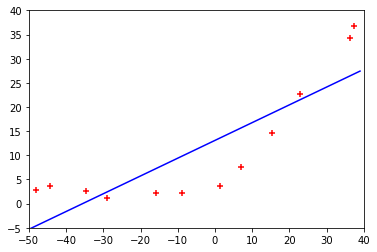

In [36]:
#add the scatter plot of data (as above) 

plt.scatter(X[:, 0], y[:, 0], c="r", marker="+")

#Plot the best linear model
x_fit=range(-50,40)
y_fit=theta[1]+theta[0]*x_fit
plt.plot(x_fit,y_fit,color="b")

plt.ylim(-5,40)
plt.xlim(-50,40)

### Bias-variance and learning curves 

An important concept in ML is the **bias-variance** tradeoff. 

Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data. 

Now, you will plot training and CV/dev learning curves to diagnose bias-variance problems. 
To plot the learning curve, we need training and CV errors for different training set sizes. To obtain different training set sizes, *learningCurve* use different subsets of the original training set X. Specifically, for a training 
set size of i, the first i examples (i.e., X(0:i,:) and y(0:i)) are used.


In [37]:
def learningCurve(X, y, Xval, yval, learn_rate, num_iter, Lambda):
    
    """
    Returns the train and cross validation set errors for a learning curve
    """
   
    m = len(X)  # Number of training examples 
    n=2  # number of features 
    mval =len(Xval)  # Number of validation examples 

    error_train, error_val = [],[]
    
    for i in range(1,m+1):
        
        # inicialize all theta at 0. 
        initial_theta=np.zeros((1,1))
        Xtrain=X[0:i,:]
        ytrain=y[0:i,:]
        theta = gradientDescent( Xtrain, ytrain,initial_theta,learn_rate,num_iter,Lambda)[0]
        
        h_train = np.dot(Xtrain, theta)
        h_val = np.dot(Xval, theta)
        
        error_train_i = 1/(2*m) * np.sum((h_train - ytrain)**2)
        error_val_i = 1/(2*mval) * np.sum((h_val - yval)**2)
        
        error_train.append(error_train_i)
        error_val.append(error_val_i)

    return error_train, error_val
    
    

# add an extra columns of 1 to Xval
Xval_1 = np.append(Xval,np.ones((len(Xval),1)),axis=1)

#Call learningCurve to compute E_train and E_validation
error_train, error_val = learningCurve(X, y, Xval_1, yval, learn_rate, num_iter, Lambda)

In [38]:
#Xval_1= np.append(Xval,np.ones((len(Xval),1)),axis=1)
Xval_1 = Xval

error_train, error_val = learningCurve(X, y, Xval_1, yval, learn_rate, num_iter, Lambda)

### Plot the learning curves

Plot the learning curves as shown in Fig. 3. You can observe that both the training and the cross validation errors are high even when the number of training examples increases. This reflects a high bias problem of the model. 

<img src="images/f3.png" style="width:350px;height:250px;">
<caption><center> **Fig.3** : **Linear Regression learning curves** </center></caption>

(-10.0, 210.0)

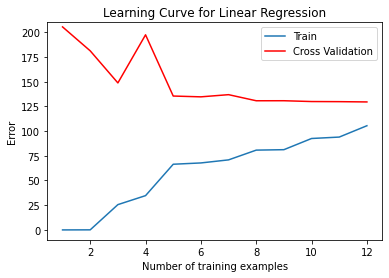

In [39]:
plt.plot(range(1,m+1),error_train)
plt.plot(range(1,m+1), error_val,color="r")
plt.title("Learning Curve for Linear Regression")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.legend(["Train", "Cross Validation"])
plt.ylim(-10,210)



### Polynomial Regression

The linear model is too simple for this data and resulted in underfitting (high bias). Now, you will address this problem by adding more features using higher powers of the original feature (waterLevel), such as:

<img src="images/f4.png" style="width:450px;height:50px;">
<caption><center> **Fig.4**: **Polynomial Regression model** </center></caption>

Keep in mind that even though we have polynomial terms in the model above, we are still solving a linear regression optimization problem. The polynomial terms are simply new features that we can use for linear regression. The function *polyFeatures* maps the original training set X of size mx1 into its higher powers. Specifically, when a training set X of size mx1 is passed into the function, the function should return a mxp matrix X_poly, where 1st column holds the original values of X, 2nd column holds the values of $X^2$,  3rd column holds the values of $X.^3$, and so on. 

Function *polyFeatures* is applied to the training, cross validation and test data.  



In [40]:
def polyFeatures(X, degree):
    """
    Takes a data matrix X (size m x 1) and maps each example into its polynomial features where 
    X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^degree];
    """
    m=len(X)  # Number of training examples 
    
    for i in range(2,degree+1):
        var=X[:,0]**i
        X = np.append(X, var.reshape(m,1), axis=1)
        
    return X

### Feature Normalization

After adding polynomial terms, the new features are badly scaled. Let assume a polynomial of degree 8, an example with x = 40 will now have a feature x8 = 40^8 = 6.5x10^12. Therefore, before training the model, the features of the training set are first normalized. Here *StandardScaler()* function is used, that standardize the features by removing the mean and scaling to unit variance. Check *StandardScaler?* for more details. 

In [64]:
help(polyFeatures)

Help on function polyFeatures in module __main__:

polyFeatures(X, degree)
    Takes a data matrix X (size m x 1) and maps each example into its polynomial features where 
    X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^degree];



In [75]:
from sklearn.preprocessing import StandardScaler

# Map X onto Polynomial features (call polyFeatures)
degree=8
X_poly = polyFeatures(X,degree)


#Check the range of values for the polynomial features



# Standardize the features by removing the mean and scaling to unit variance. 
sc_X=StandardScaler()
sc_X.fit(X_poly)  #Fit the scaller ONLY to the TRAINING DATA
X_poly_normalized=sc_X.transform(X_poly) #Transform the training data 

#Check the range of values for the standardized features 


#Add an extra column of 1' to X_poly
X_poly_normalized =np.append(X_poly,np.ones((len(X_poly),1)),axis=1)


Map CV and test sets onto polynomial features. 
Apply the fitted (with the training data) scaler to them. 

DO NOT FIT AGAIN THE SCALER !!!

In [81]:
# Map Xval and Xtest onto polynomial features and normalize
X_poly_val = polyFeatures(Xval,degree)
X_poly_test =polyFeatures(Xtest,degree)

#ONLY apply the fitted StandardScaler 
#DO NOT FIT IT AGAIN (all scallers/normalizers are fitted only with the training data)
X_poly_val_normalized = sc_X.transform(X_poly_val)
X_poly_test_normalized= sc_X.transform(X_poly_test)

#Add an extra column of 1' to each matrix
X_poly_val_normalized = np.append(X_poly_val_normalized,np.ones((len(X_poly_val_normalized),1)),axis=1)
X_poly_test_normalized= np.append(X_poly_test_normalized,np.ones((len(X_poly_test_normalized),1)),axis=1)


### Learning Polynomial Regression

The training of the polynomial model uses the same linear regression cost function and gradient as above. 

<img src="images/f7.png" style="width:350px;height:250px;">
<caption><center> **Fig.5**: **Cost function trajectory** </center></caption>

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


<ipython-input-32-51f610ea191e>:15: RuntimeWarning: overflow encountered in square
  square_err=np.square(h-y)
<ipython-input-32-51f610ea191e>:17: RuntimeWarning: overflow encountered in square
  reg_cost = cost + Lambda/(2*m) * (np.sum(theta[1:]**2))
<ipython-input-32-51f610ea191e>:17: RuntimeWarning: invalid value encountered in double_scalars
  reg_cost = cost + Lambda/(2*m) * (np.sum(theta[1:]**2))
<ipython-input-32-51f610ea191e>:21: RuntimeWarning: invalid value encountered in multiply
  grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]


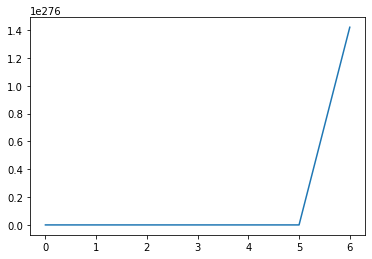

In [92]:
#n is now the new number of features after adding polynomial terms
n= "não faço ideia"

Lambda=0
num_iter= 10000
learn_rate=0.001

# inicialize all theta at 0. 
init_theta= np.zeros((9,1))
print(init_theta)

#call gradientDescent to get the optimal parameters theta
theta_poly, J_history_poly = gradientDescent(X_poly_normalized,y,init_theta,learn_rate,num_iter,Lambda)

#Get Fig.5
plt.plot(J_history_poly)


### Polynomial Regression - learning curve

After training is over, you should get Figs. 6 and Fig.7 generated for $\lambda$=0.
The polynomial fit is able to follow the data points very well (Fig.6) and therefore the training error is very low (Fig.7). However, there is a gap between the training and CV errors (Fig.7), indicating a high variance problem due to the lack of regularization ( $\lambda$=0). 

<img src="images/f5.png" style="width:350px;height:250px;">
<caption><center> **Fig.6**: **Polynomial Fit** </center></caption>


<img src="images/f6.png" style="width:350px;height:250px;">
<caption><center> **Fig.7**: **Linear Regression learning curves** </center></caption>

In [ ]:
#Fig.6
#add the scatter plot of data (as above) 
?

xmin = np.min(X) - 15
xmax=np.max(X) + 25

#Generate a grid of values for x coordinate
x_value=np.linspace(xmin,xmax,2400)
x_value=x_value.reshape(x_value.shape[0],1)

# Map the x values and normalize
x_value_poly = polyFeatures(x_value, degree)
x_value_poly = sc_X.transform(x_value_poly)
x_value_poly = np.append(np.ones((x_value_poly.shape[0],1)),x_value_poly, axis=1)

#Compute the model prediction for x values 
y_value= np.dot(x_value_poly, theta_poly)

plt.plot(x_value,y_value,"--",color="b")
plt.ylim(-5,160)


In [ ]:
#Call learningCurve to compute E_train and E_cv
error_train, error_val = ?


In [ ]:
# Fig.7

plt.plot(range(m),error_train,label="Train")
plt.plot(range(m),error_val,label="Cross Validation",color="r")

plt.title("Learning Curve for Linear Regression")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.legend()
plt.ylim(0,100)


### Polynomial regression with $\lambda$ =  [0.001; 0.003; 0.01; 0.03; 0.1; 0.3; 1; 3; 10] ) 

Find the best $\lambda$ from a grid search and compute the training, validation and test errors. 

In [ ]:
def validationCurve (X, y, Xval, yval, learn_rate, num_iter, Lambda_array):

    """
    Returns the best lambda and the respective train and cross validation set errors
    """
    m = ?  # Number of training examples 
    n=?  # number of features 
    mval = ?  # Number of validation examples 
    
    error_train, error_val = [],[]
    
    for lam in Lambda_array:
        theta_ini=np.zeros((n,1))
        theta = gradientDescent( X, y,theta_ini,learn_rate,num_iter,lam)[0]
        
        #After the training is over, apply the trained model for train and validation data
        pred_train = np.dot(X,theta)
        pred_val = np.dot(Xval,theta)
        
        #Compute the train and validation error
        error_train_i = 1/(2*m) * np.sum((pred_train - y)**2)
        error_val_i = 1/(2*mval) * np.sum((pred_val - yval)**2)
        
        error_train.append(error_train_i)
        error_val.append(error_val_i)
    
    #Choose the best lambda to be the one that minimizes the validation error
    ind = np.argmin(error_val)
    best_lambda=Lambda_array[ind]
        
    return best_lambda, error_train, error_val

In [ ]:
Lambda_array = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

best_lambda, error_train, error_val = validationCurve(X_poly_normalized, y, X_poly_val_normalized, yval, learn_rate, num_iter, Lambda_array)

print(best_lambda)

plt.plot(Lambda_array,error_train,label="Train")
plt.plot(Lambda_array,error_val,label="Cross Validation",color="r")
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.legend()

#for the best_lambda computed above, print the training (Etrain), validation (Eval) and test (Etest) errors

# inicialize all theta at 0. 
theta_ini=?
theta_poly = gradientDescent(X_poly_normalized, y,theta_ini,learn_rate,num_iter,best_lambda)[0]

pred = np.dot(X_poly_normalized,theta_poly)
Etrain = 1/(2*m) * np.sum((pred - y)**2)

pred_val = np.dot(X_poly_val_normalized,theta_poly)
Eval = 1/(2*mval) * np.sum((pred_val - yval)**2)

pred_test = np.dot(X_poly_test_normalized, theta_poly)
Etest = 1/(2*mtest) * np.sum((pred_test - ytest)**2)

print(Etrain)
print(Eval)
print(Etest)
